# Book Recommendation System

## 1. Import Library

In [1]:
import numpy as np
import pandas as pd
import pickle
from collections import defaultdict
import heapq
from operator import itemgetter
from surprise import Reader
from surprise import Dataset
from surprise import KNNBaseline, KNNBasic, KNNWithMeans, KNNWithZScore, CoClustering, SVD, SVDpp
from surprise.model_selection import train_test_split
from surprise.model_selection import cross_validate
from surprise.model_selection import GridSearchCV
from surprise import accuracy
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('bmh')
%config InlineBackend.figure_format = 'retina'
pd.set_option('display.max_colwidth', -1)

In [2]:
class display(object):
    """Display HTML representation of multiple objects"""
    template = """<div style="float: left; padding: 10px;">
    <p style='font-family:"Courier New", Courier, monospace'>{0}</p>{1}
    </div>"""
    def __init__(self, *args):
        self.args = args
        
    def _repr_html_(self):
        return '\n'.join(self.template.format(a, eval(a)._repr_html_())
                         for a in self.args)
    
    def __repr__(self):
        return '\n\n'.join(a + '\n' + repr(eval(a))
                           for a in self.args)

## 2. EDA

In [3]:
# There are three dataset contains users, book and rating information.
users = pd.read_csv('BX-Users.csv', sep=';', error_bad_lines=False, encoding="latin-1")
book = pd.read_csv('BX-Books.csv', sep=';', error_bad_lines=False, escapechar='\\', encoding='latin-1')
ratings = pd.read_csv('BX-Book-Ratings.csv', sep=';', error_bad_lines=False, encoding='latin-1')

In [4]:
print('Users: ', users.shape)
print('Book: ', book.shape)
print('Ratings: ', ratings.shape)

Users:  (278858, 3)
Book:  (271379, 8)
Ratings:  (1149780, 3)


In [5]:
display('users.head()', 'ratings.head()', 'book.head(3)')

,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN
,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3


### User

In [6]:
print('Max. Age: ', users['Age'].max())
print('Min. Age: ', users['Age'].min())

Max. Age:  244.0
Min. Age:  0.0


In [7]:
users.isnull().sum()

User-ID     0     
Location    0     
Age         110762
dtype: int64

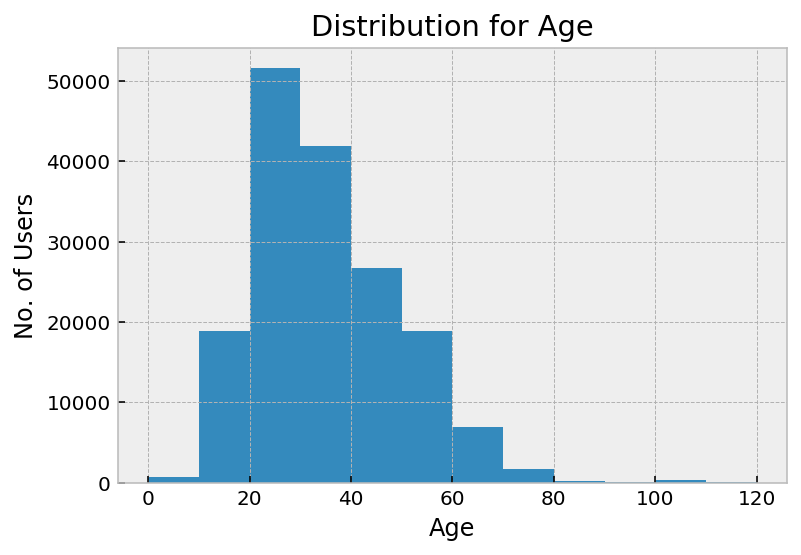

In [8]:
# Majority of the users are in age 20-40.
users.query('0 < Age < 120')['Age'].hist(bins=range(0, 121, 10))
plt.title('Distribution for Age')
plt.xlabel('Age')
plt.ylabel('No. of Users')
plt.show()

### Book

In [9]:
book.isnull().sum()

ISBN                   0
Book-Title             0
Book-Author            1
Year-Of-Publication    0
Publisher              2
Image-URL-S            0
Image-URL-M            0
Image-URL-L            0
dtype: int64

In [10]:
# Since there are only 2 missing values, we'll just drop it.
book.dropna(inplace=True)
book.drop(['Image-URL-S', 'Image-URL-M'], axis=1, inplace=True)
book.columns = ['ISBN', 'title', 'author', 'year', 'publisher', 'image']
book.head()

,ISBN,title,author,year,publisher,image
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.01.LZZZZZZZ.jpg
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.01.LZZZZZZZ.jpg
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.01.LZZZZZZZ.jpg
3,0374157065,Flu: The Story of the Great Influenza Pandemic of 1918 and the Search for the Virus That Caused It,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.01.LZZZZZZZ.jpg
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.01.LZZZZZZZ.jpg


In [11]:
# There are incorrect Year: '0' and future year.
print(sorted(book['year'].unique()))
print()
print('No. of rows with Year 0: ', book.query('year == 0').shape)
print('No. of rows with future Year: ', book.query('year >= 2020').shape)

[0, 1376, 1378, 1806, 1897, 1900, 1901, 1902, 1904, 1906, 1908, 1909, 1910, 1911, 1914, 1917, 1919, 1920, 1921, 1922, 1923, 1924, 1925, 1926, 1927, 1928, 1929, 1930, 1931, 1932, 1933, 1934, 1935, 1936, 1937, 1938, 1939, 1940, 1941, 1942, 1943, 1944, 1945, 1946, 1947, 1948, 1949, 1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2008, 2010, 2011, 2012, 2020, 2021, 2024, 2026, 2030, 2037, 2038, 2050]

No. of rows with Year 0:  (4619, 6)
No. of rows with future Year:  (17, 6)


In [12]:
# For simplicity, rows with incorrect year are replaced with mean.
# Alternatively, use webscrapping to collect and replace with correct year.
book.loc[(book['year'] == 0) | (book['year'] >= 2020)] = np.nan
book['year'] = book['year'].fillna(round(book['year'].mean()))
book['year'] = book['year'].astype(int)

### Rating

In [13]:
ratings.columns = ['user', 'ISBN', 'rating']
ratings.nunique()

user      105283
ISBN      340556
rating    11    
dtype: int64

In [14]:
ratings.isnull().sum()

user      0
ISBN      0
rating    0
dtype: int64

In [15]:
sorted(ratings['rating'].unique())

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

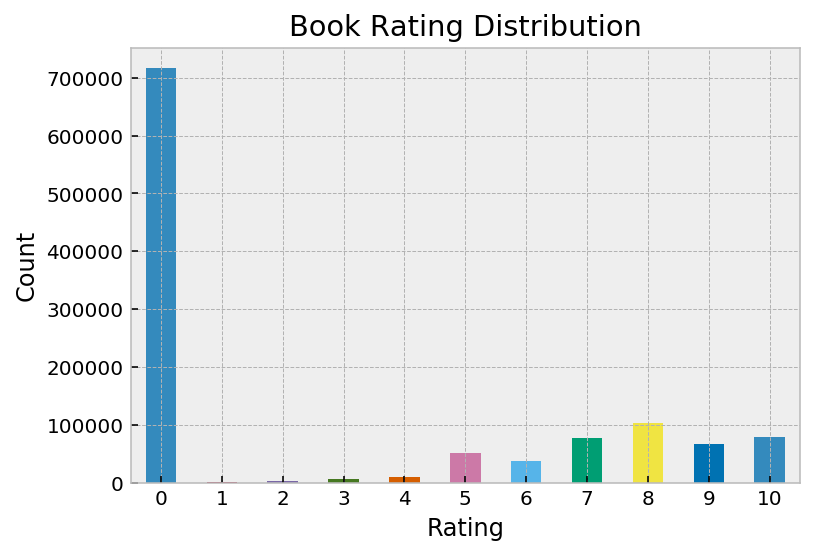

In [16]:
# Majority of the data have 0 rating.
ratings['rating'].value_counts(sort=False).plot(kind='bar')
plt.title('Book Rating Distribution')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

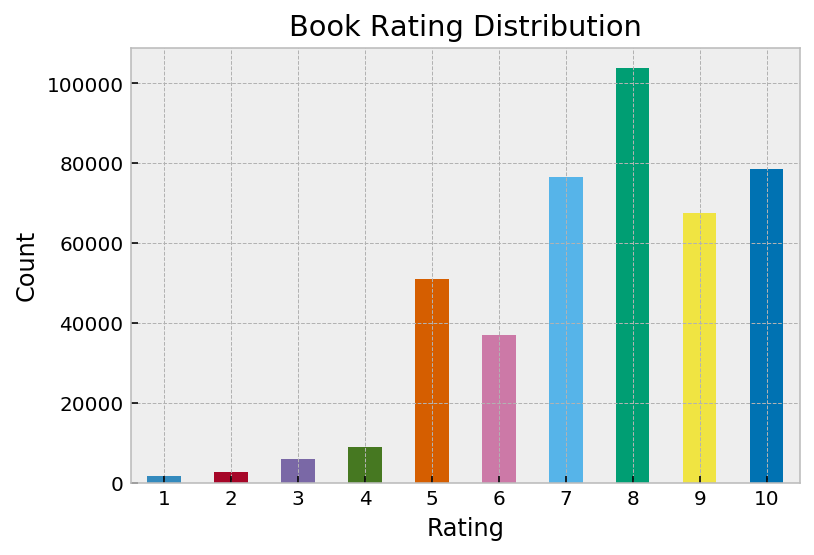

In [17]:
# For book with non-zero rating, majority has rating 8.
ratings['rating'].value_counts(sort=False)[1:].plot(kind='bar')
plt.title('Book Rating Distribution')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

### Data Sampling

In [18]:
# Join dataset on book number.
df = ratings.merge(book, how='left', on='ISBN')
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)
df.shape

(1017096, 8)

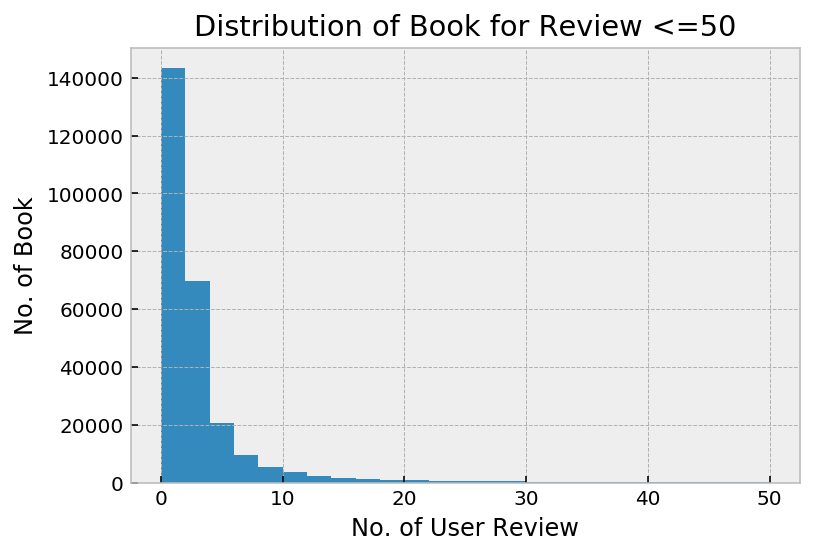

In [19]:
# Majority of book only has less than 10 reviews.
df.groupby('ISBN')['rating'].count().hist(bins=range(0, 51, 2))
plt.title('Distribution of Book for Review <=50')
plt.xlabel('No. of User Review')
plt.ylabel('No. of Book')
plt.show()

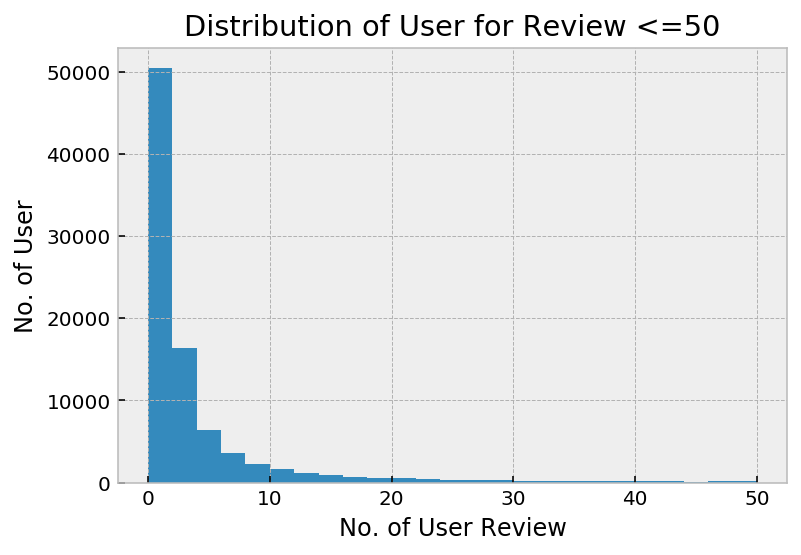

In [20]:
# The distribution is similar for users.
df.groupby('user')['rating'].count().hist(bins=range(0, 51, 2))
plt.title('Distribution of User for Review <=50')
plt.xlabel('No. of User Review')
plt.ylabel('No. of User')
plt.show()

In [21]:
# We will choose books with more than 10 reviews.
book_rating = df.groupby('ISBN').count()['rating']
user_rating = df.groupby('user').count()['rating']

# We will choose users rated more than 10 book.
isbn = book_rating[book_rating <= 10].index
user_id = user_rating[user_rating <= 10].index

# And we will only use explicit rating (rating > 0) to build the recommender system.
idx = df.query('ISBN in @isbn or rating == 0 or user in @user_id').index
cf = df.drop(idx)
cf.shape

(134215, 8)

In [22]:
cf.head()

,user,ISBN,rating,title,author,year,publisher,image
26,276762,0380711524,5,See Jane Run,Joy Fielding,1992.0,Avon,http://images.amazon.com/images/P/0380711524.01.LZZZZZZZ.jpg
93,276822,0060096195,10,The Boy Next Door,Meggin Cabot,2002.0,Avon Trade,http://images.amazon.com/images/P/0060096195.01.LZZZZZZZ.jpg
97,276822,0375821813,9,Hoot (Newbery Honor Book),CARL HIAASEN,2002.0,Knopf Books for Young Readers,http://images.amazon.com/images/P/0375821813.01.LZZZZZZZ.jpg
103,276822,0786817070,10,"Artemis Fowl (Artemis Fowl, Book 1)",Eoin Colfer,2002.0,Miramax Kids,http://images.amazon.com/images/P/0786817070.01.LZZZZZZZ.jpg
128,276847,3404148576,8,Nordermoor,Arnaldur Indridason,2003.0,LÃ?Â¼bbe,http://images.amazon.com/images/P/3404148576.01.LZZZZZZZ.jpg


In [23]:
cf.nunique()

user         9866 
ISBN         14981
rating       10   
title        13279
author       4837 
year         63   
publisher    890  
image        14981
dtype: int64

In [24]:
cf['year'] = cf['year'].astype(int)

In [ ]:
# Convert book data to json format.

# test = cf[['ISBN', 'title', 'author', 'year', 'image']].drop_duplicates()
# test.to_json(orient='records').replace('\\', '')

In [29]:
cf.user.unique().min()

8

## 3. Popularity-based Recommendation System

In [ ]:
# Recommend based on number of customer reviews.
top20 = cf.groupby('ISBN').count().sort_values(ascending=False, by='rating').head(20).index
print('Top 20 Popular book:')
book.query('ISBN in @top20').drop('image', axis=1)

Top 20 Popular book:


,ISBN,title,author,year,publisher
26,0971880107,Wild Animus,Rich Shapero,2004,Too Far
107,0786868716,The Five People You Meet in Heaven,Mitch Albom,2003,Hyperion
118,0671027360,Angels &amp; Demons,Dan Brown,2001,Pocket Star
231,0452282152,Girl with a Pearl Earring,Tracy Chevalier,2001,Plume Books
305,044023722X,A Painted House,John Grisham,2001,Dell Publishing Company
356,0142001740,The Secret Life of Bees,Sue Monk Kidd,2003,Penguin Books
408,0316666343,The Lovely Bones: A Novel,Alice Sebold,2002,"Little, Brown"
456,044021145X,The Firm,John Grisham,1992,Bantam Dell Publishing Group
522,0312195516,The Red Tent (Bestselling Backlist),Anita Diamant,1998,Picador USA
563,0156027321,Life of Pi,Yann Martel,2003,Harvest Books


In [ ]:
# Recommend based on total rating score.
top20 = cf.groupby('ISBN').sum().sort_values(ascending=False, by='rating').head(20).index
print('Top 20 Popular book:')
book.query('ISBN in @top20').drop('image', axis=1)

Top 20 Popular book:


,ISBN,title,author,year,publisher
37,0446310786,To Kill a Mockingbird,Harper Lee,1988,Little Brown &amp; Company
107,0786868716,The Five People You Meet in Heaven,Mitch Albom,2003,Hyperion
118,0671027360,Angels &amp; Demons,Dan Brown,2001,Pocket Star
231,0452282152,Girl with a Pearl Earring,Tracy Chevalier,2001,Plume Books
356,0142001740,The Secret Life of Bees,Sue Monk Kidd,2003,Penguin Books
408,0316666343,The Lovely Bones: A Novel,Alice Sebold,2002,"Little, Brown"
456,044021145X,The Firm,John Grisham,1992,Bantam Dell Publishing Group
522,0312195516,The Red Tent (Bestselling Backlist),Anita Diamant,1998,Picador USA
563,0156027321,Life of Pi,Yann Martel,2003,Harvest Books
706,0446672211,Where the Heart Is (Oprah's Book Club (Paperback)),Billie Letts,1998,Warner Books


In [ ]:
# Recommend based on mean rating score.
top20 = cf.groupby('ISBN').mean().sort_values(ascending=False, by='rating').head(20).index
print('Top 20 Popular book:')
book.query('ISBN in @top20').drop('image', axis=1)

Top 20 Popular book:


,ISBN,title,author,year,publisher
266,0312156960,The Winter King: A Novel of Arthur (The Warlord Chronicles: I),Bernard Cornwell,1997,St. Martin's Griffin
2792,0671721046,The Deed of Paksenarrion,Elizabeth Moon,1992,Baen
4876,0380701006,Inside-Outside Book of New York City,Herman Wouk,1986,Avon Books
8970,8432215333,El Perfume: Historia De UN Asesino,Patrick Suskind,1998,Editorial Seix Barral
11788,0553380400,Bingo,Rita Mae Brown,1999,Bantam
18637,042517428X,The Burning Point,Mary Jo Putney,2000,Berkley Publishing Group
20191,0064462080,Red Scarf Girl : A Memoir of the Cultural Revolution,Ji-li Jiang,1998,HarperTrophy
27972,0590996835,Matilda,Roald Dahl,1996,Scholastic Inc.
32551,0425050564,Shadowland,Peter Straub,1981,Berkley Publishing Group
36267,0060175869,From Dawn to Decadence: 1500 to the Present: 500 Years of Western Cultural Life,Jacques Barzun,2000,HarperCollins


## 4. User-based Collaborative Filtering

### Model Selection

In [ ]:
# Checkpoint to save df
# with open("cf.pkl", "wb") as f:
#     pickle.dump(cf, f)

In [ ]:
reader = Reader(rating_scale=(1, 10))
data = Dataset.load_from_df(cf[['user', 'ISBN', 'rating']], reader)

In [ ]:
# Compare RMSE for different models.
benchmark = []

sim_options = {'name': 'cosine',
               'user_based': True
               }
algos = [
    KNNBaseline(sim_options=sim_options),
    KNNBasic(sim_options=sim_options),
    KNNWithMeans(sim_options=sim_options),
    KNNWithZScore(sim_options=sim_options)
]

for algo in algos:
    results = cross_validate(algo, data, measures=['RMSE'], cv=3, verbose=False)
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algo).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark.append(tmp)
    
pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse') 

Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity mat

,test_rmse,fit_time,test_time
Algorithm,,,
KNNWithZScore,1.758760,3.987740,1.294089
KNNWithMeans,1.767997,3.829877,1.204683
KNNBaseline,1.768247,3.894631,1.301724
KNNBasic,1.974061,3.713070,1.162967


### Top N Recommender System

In [ ]:
# Build recommendation system using KNNWithZScore.
testSubject = 2033
k = 20

trainset = data.build_full_trainset()

sim_options = {'name': 'cosine',
               'user_based': True
               }

model = KNNWithZScore(sim_options=sim_options)
model.fit(trainset)
simsMatrix = model.compute_similarities()
print()

# Get top k similar users to our test subject.
testUserInnerID = trainset.to_inner_uid(testSubject)
similarityRow = simsMatrix[testUserInnerID]

similarUsers = []
for innerID, score in enumerate(similarityRow):
    if (innerID != testUserInnerID):
        similarUsers.append((innerID, score))

kNeighbors = heapq.nlargest(k, similarUsers, key=lambda t: t[1])

# Get the items that similar users rated.
results = defaultdict(list)
for similarUser in kNeighbors:
    innerID = similarUser[0]
    userSimilarityScore = similarUser[1]
    theirRatings = trainset.ur[innerID]
    for item_inner_id, rating in theirRatings:
        results[item_inner_id].append((userSimilarityScore, rating))

# Predict ratings for each item, weighted by user similarity.
candidates = defaultdict(float)
for item_inner_id, ratings in results.items():
    sim_rating = 0
    sim_sum = 0
    for similarity, rating in ratings:
        sim_rating += similarity * rating
        sim_sum += similarity
    pred_rating = sim_rating / sim_sum
    candidates[item_inner_id] = pred_rating
    
# Build a dictionary of items the user has already read.
read = {}
for itemID, rating in trainset.ur[testUserInnerID]:
    read[itemID] = 1
    
# Get top-rated items from similar users.
def get_top_n(candidates, testSubject=testSubject, k=20):
    '''Return the top-N recommendation for each user from a set of candidates.

    Args:
        candidates(dict): The dictionary of predicted results.
                          Key: user/item inner_id based on similarity matrix
                          Value: predicted rating
                          
        testSubject(int): User ID for recommendation.
        
        k(int): Number of top recommendations.

    Returns:
        DataFrame for top k recommendated book.
        Columns: book_id, title, author and year of published.
    '''
    results = {'book_id': [], 'title': [], 'author': [], 'year': []}
    pos = 0

    for itemID, rating in sorted(candidates.items(), key=itemgetter(1), reverse=True):
        if not itemID in read:
            bookID = trainset.to_raw_iid(itemID)
            title = cf[cf['ISBN'] == bookID].title.unique()[0]
            author = cf[cf['ISBN'] == bookID].author.unique()[0]
            year = cf[cf['ISBN'] == bookID].year.unique()[0]

            results['book_id'].append(bookID)
            results['title'].append(title)
            results['author'].append(author)
            results['year'].append(int(year))

            pos += 1
            if (pos == k):
                break

    print('Recommendation for User {}:'.format(testSubject))
    return pd.DataFrame(results)

get_top_n(candidates)

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.

Recommendation for User 2033:


,book_id,title,author,year
0,0836218833,Attack Of The Deranged Mutant Killer Snow Goons,Bill Watterson,1992
1,0380789035,American Gods,Neil Gaiman,2002
2,0380973634,Neverwhere,Neil Gaiman,1997
3,0380815931,In the Beginning...was the Command Line,Neal Stephenson,1999
4,0385504209,The Da Vinci Code,Dan Brown,2003
5,0553373803,The Fifth Sacred Thing,Starhawk,1994
6,0671721046,The Deed of Paksenarrion,Elizabeth Moon,1992
7,0440219078,The Giver (21st Century Reference),LOIS LOWRY,1994
8,0440998050,A Wrinkle in Time,Madeleine L'Engle,1976
9,0553213377,The Three Musketeers (Bantam Classics),ALEXANDRE DUMAS,1984


### Define Rating Threshold

In [ ]:
# Build recommendation system using KNNWithZScore.
testSubject = 2033
k = 10

trainset = data.build_full_trainset()

sim_options = {'name': 'cosine',
               'user_based': True
               }

model = KNNWithZScore(sim_options=sim_options)
model.fit(trainset)

# Build user similarity matrix (N x N).
simsMatrix = model.compute_similarities()
print()

# Get top k similar users to our test subject.
testUserInnerID = trainset.to_inner_uid(testSubject)
similarityRow = simsMatrix[testUserInnerID]

similarUsers = []
for innerID, score in enumerate(similarityRow):
    if (innerID != testUserInnerID):
        similarUsers.append((innerID, score))

# Define similarity threshold.
kNeighbors = []
for rating in similarUsers:
    if rating[1] > 0.95:
        kNeighbors.append(rating)
    
# Get the items that similar users rated.
results = defaultdict(list)
for similarUser in kNeighbors:
    innerID = similarUser[0]
    userSimilarityScore = similarUser[1]
    theirRatings = trainset.ur[innerID]
    for item_inner_id, rating in theirRatings:
        results[item_inner_id].append((userSimilarityScore, rating))

# Predict ratings for each item, weighted by user similarity.
candidates = defaultdict(float)
for item_inner_id, ratings in results.items():
    sim_rating = 0
    sim_sum = 0
    for similarity, rating in ratings:
        sim_rating += similarity * rating
        sim_sum += similarity
    pred_rating = sim_rating / sim_sum
    candidates[item_inner_id] = pred_rating
    
# Build a dictionary of stuff the user has already seen.
read = {}
for itemID, rating in trainset.ur[testUserInnerID]:
    read[itemID] = 1
    
# Get top-rated items from similar users.
get_top_n(candidates)

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.

Recommendation for User 2033:


,book_id,title,author,year
0,006019250X,The Illustrated Alchemist: A Fable About Following Your Dream,Paulo Coelho,1998
1,0060809736,Death Be Not Proud: A Memoir,John Gunther,1989
2,0060953691,La Cucina: A Novel of Rapture,Lily Prior,2001
3,0061099341,As the Crow Flies,Jeffrey Archer,1992
4,0061099708,Colony,Anne Rivers Siddons,1993
5,0142300497,Island of the Aunts,Eva Ibbotson,2001
6,030700645X,"Eeyore, Be Happy (Little Golden Book)",Don Ferguson,1996
7,0312063571,Flowers in the Rain,Rosamunde Pilcher,1991
8,0312906013,Herbs and Apples,Helen Santmyers,1987
9,0312967004,Eleven Hours,Paullina Simons,1999


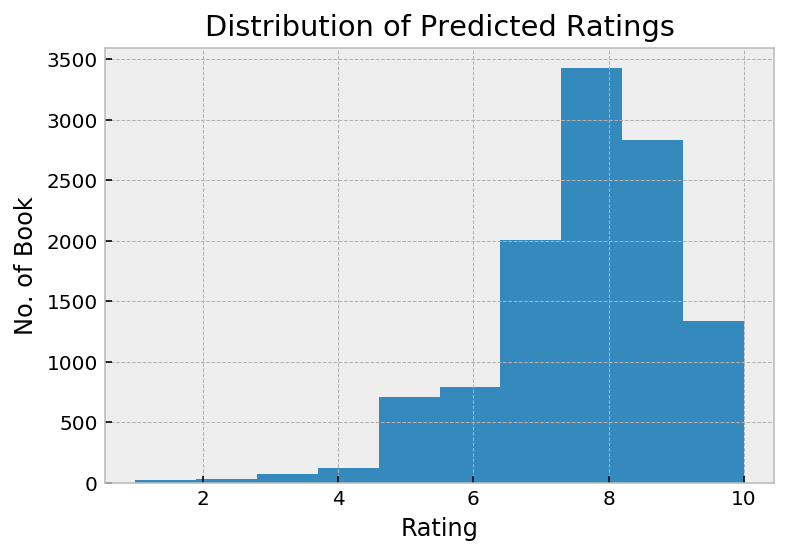

In [ ]:
# Check the distribution of predicted ratings.
pd.Series(candidates).hist()
plt.title('Distribution of Predicted Ratings')
plt.xlabel('Rating')
plt.ylabel('No. of Book')
plt.show()

## 5. Item-based Collaborative Filtering

### Model Selection

In [ ]:
# Compare RMSE for different models.
benchmark = []

sim_options = {'name': 'pearson',
               'user_based': False
               }
algos = [
    KNNBaseline(sim_options=sim_options),
    KNNBasic(sim_options=sim_options),
    KNNWithMeans(sim_options=sim_options),
    KNNWithZScore(sim_options=sim_options)
]

for algo in algos:
    results = cross_validate(algo, data, measures=['RMSE'], cv=3, verbose=False)
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algo).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark.append(tmp)
    
pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse') 

Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing si

,test_rmse,fit_time,test_time
Algorithm,,,
KNNBaseline,1.633854,15.832390,2.586932
KNNBasic,1.779830,14.871321,2.470349
KNNWithMeans,1.857458,17.555170,2.775304
KNNWithZScore,1.857857,16.226712,2.639770


### Top N Recommender System

In [ ]:
# Build recommendation system using KNNBaseline.
testSubject = 2033
k = 10

trainset = data.build_full_trainset()

sim_options = {'name': 'pearson',
               'user_based': False
               }

model = KNNBaseline(sim_options=sim_options)
model.fit(trainset)
simsMatrix = model.compute_similarities()
print()

testUserInnerID = trainset.to_inner_uid(testSubject)

# Get the top K items we rated.
testUserRatings = trainset.ur[testUserInnerID]
kNeighbors = heapq.nlargest(k, testUserRatings, key=lambda t: t[1])

# Get similar items to stuff we liked (weighted by rating).
candidates = defaultdict(float)
for itemID, rating in kNeighbors:
    similarityRow = simsMatrix[itemID]
    for innerID, similarity in enumerate(similarityRow):
        candidates[innerID] += similarity * rating
    
# Build a dictionary of stuff the user has already seen.
read = {}
for itemID, rating in trainset.ur[testUserInnerID]:
    read[itemID] = 1
    
# Get top-rated items.
get_top_n(candidates)

Estimating biases using als...
Computing the pearson similarity matrix...


### Define Rating Threshold

In [ ]:
# Build recommendation system using KNNBaseline.
testSubject = 2033
k = 10

trainset = data.build_full_trainset()

sim_options = {'name': 'pearson',
               'user_based': False
               }

model = KNNBaseline(sim_options=sim_options)
model.fit(trainset)
simsMatrix = model.compute_similarities()
print()

testUserInnerID = trainset.to_inner_uid(testSubject)

# Get the top K items we rated.
testUserRatings = trainset.ur[testUserInnerID]
kNeighbors = []
for rating in testUserRatings:
    if rating[1] > 5.0:
        kNeighbors.append(rating)
        
# Get similar items to stuff we liked (weighted by rating).
candidates = defaultdict(float)
for itemID, rating in kNeighbors:
    similarityRow = simsMatrix[itemID]
    for innerID, score in enumerate(similarityRow):
        candidates[innerID] += score * (rating / 5.0)
    
# Build a dictionary of stuff the user has already seen.
read = {}
for itemID, rating in trainset.ur[testUserInnerID]:
    read[itemID] = 1
    
# Get top-rated items.
get_top_n(candidates)

## 6. Matrix Factorization

In [ ]:
# We will further downsize the dataset for computation efficiency.
isbn = book_rating[book_rating <= 50].index
user_id = user_rating[user_rating <= 50].index
idx = df.query('ISBN in @isbn or rating == 0 or user in @user_id').index
cf = df.drop(idx)

reader = Reader(rating_scale=(1, 10))
data = Dataset.load_from_df(cf[['user', 'ISBN', 'rating']], reader)

### SVD

In [ ]:
# Build trainset.
trainset = data.build_full_trainset()

# Build anti_testset where ratings are those not in the trainset.
testset = trainset.build_anti_testset()

# Tune the parameters for SVD.
param_grid = {'n_epochs': [10, 20], 'lr_all': [0.01, 0.02],
              'n_factors': [2, 5]}
gs = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=3)
gs.fit(data)
print('Best RMSE: ', gs.best_score['rmse'])
print('Best Parameters: ', gs.best_params['rmse'])

In [ ]:
# We can now use the algorithm that yields the best rmse.
svd = gs.best_estimator['rmse']
predictions = svd.fit(trainset).test(testset)
accuracy.rmse(predictions)

In [ ]:
# Let's check some predicted ratings.
results = pd.DataFrame(predictions, columns=['user_id', 'book_id', 'rating', 'pred_rating', 'details'])
results.sample(10)

In [ ]:
# with open('pred_svd.pkl', 'wb') as f:
#     pickle.dump(predictions, f)

In [ ]:
# with open('pred_svd.pkl', "rb") as f:
#     predictions = pickle.load(f)

In [ ]:
# Make Top N recommendations.
def model_top_n(predictions, testSubject=2033, n=10):
    '''Return the top-N recommendation for each user from a set of predictions.

    Args:
        
        predictions(list of Prediction objects): The list of predictions, as
        returned by the test method of an algorithm.
        
        testSubject(int): User ID for recommendation.
        
        n(int): The number of recommendation to output for each user. Default
            is 10.

    Returns:
    
        DataFrame for top k recommendated book.
        Columns: book_id, title, author and year of published.
    '''
    predictions = pd.DataFrame(predictions, columns=['user_id', 'book_id', 'rating', 'pred_rating', 'details'])
    user = predictions[predictions['user_id'] == testSubject]
    user_top_n = user.sort_values(by='rating', ascending=False).head(n)
    
    results = {'book_id': [], 'title': [], 'author': [], 'year': []}
    
    for iid in user_top_n['book_id']:
        bookID = iid
        title = cf[cf['ISBN'] == iid].title.unique()[0]
        author = cf[cf['ISBN'] == iid].author.unique()[0]
        year = cf[cf['ISBN'] == iid].year.unique()[0]

        results['book_id'].append(bookID)
        results['title'].append(title)
        results['author'].append(author)
        results['year'].append(int(year))

    print('Recommendation for user {}'.format(testSubject))
    return pd.DataFrame(results)

model_top_n(predictions)

### SVD++

In [ ]:
# Build trainset.
trainset = data.build_full_trainset()

# Build anti_testset where ratings are those not in the trainset.
testset = trainset.build_anti_testset()

# Tune the parameters for SVD.
param_grid = {'n_epochs': [10, 20], 'lr_all': [0.005, 0.01],
              'n_factors': [5, 10]}
gs = GridSearchCV(SVDpp, param_grid, measures=['rmse'], cv=3)
gs.fit(data)
print('Best RMSE: ', gs.best_score['rmse'])
print('Best Parameters: ', gs.best_params['rmse'])

In [ ]:
# We can now use the algorithm that yields the best rmse.
svdpp = gs.best_estimator['rmse']
predictions = svdpp.fit(trainset).test(testset)
accuracy.rmse(predictions)

In [ ]:
# Let's check some predicted ratings.
results = pd.DataFrame(predictions, columns=['user_id', 'book_id', 'rating', 'pred_rating', 'details'])
results.sample(10)

In [ ]:
# The predictions are the same as SVD.
model_top_n(predictions)